## What we have to do:
1. Import needed modules
2. Prepare data in folders in the structure keras wants
3. Instantiate Vgg16
4. Finetune
5. Train
7. Save weights
8. Make predictions
9. Save predictions to .csv
6. Submit to kaggle

In [13]:
%matplotlib inline
import numpy as np
import os
from shutil import copyfile
from random import shuffle
import keras
from keras.models import Model
from keras.layers import Dense
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import confusion_matrix
from utils import plots,plot_confusion_matrix

In [2]:
CWD = os.getcwd()
# dimensions of our images.
img_width, img_height = 224, 224

In [3]:
DATA_SOURCE = 'all_data'

#### Prepare data batches

In [4]:
train_size=50
valid_size=50
train_batches = ImageDataGenerator().flow_from_directory(
    os.path.join(CWD, DATA_SOURCE, 'train'),
    target_size=(img_height, img_width),
    batch_size=train_size,
    shuffle=True    
)
valid_batches = ImageDataGenerator().flow_from_directory(
    os.path.join(CWD, DATA_SOURCE, 'valid'),
    target_size=(img_height, img_width),
    batch_size=valid_size,
    shuffle=False
)

Found 21250 images belonging to 2 classes.
Found 3750 images belonging to 2 classes.


#### Instantiate VGG16

In [19]:
from vgg16 import VGG16
vgg16 = VGG16()

In [20]:
vgg16.layers.pop()

In [21]:
for layer in vgg16.layers: layer.trainable=False

#### Finetuning

In [ ]:
# recover the output from the last layer in the model and use as input to new Dense layer
last = vgg16.layers[-1].output
x = Dense(train_batches.num_classes, activation='softmax')(last)
vgg16 = Model(vgg16.input, x)

In [ ]:
vgg16.compile(optimizer=Adam(lr=0.001), loss="categorical_crossentropy", metrics=["accuracy"])

In [ ]:
vgg16.summary()

In [ ]:
for layer in vgg16.layers:
    print('{} - {}'.format(layer.name, layer.trainable))

#### Training

In [ ]:
vgg16.fit_generator(train_batches, 
                    steps_per_epoch=train_batches.samples/train_size,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.samples/valid_size,
                    epochs=2,
                   )

#### Make Predictions

In [24]:
valid_batches.reset()
predictions = vgg16.predict_generator(valid_batches,
                                      steps=valid_batches.samples/valid_size,
                                      verbose=1
                                     )

75/75 [==============================] - 21s 275ms/step


#### Vizualize

Confusion matrix, without normalization
[[1813   40]
 [  46 1851]]


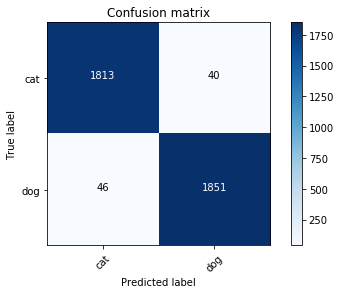

In [26]:
# to build the confusion matrix you need binary data, not floats
cm = confusion_matrix(valid_batches.classes.astype(dtype='float32')[:len(predictions)], np.around(predictions)[:,1])
plot_confusion_matrix(cm, ['cat', 'dog'])

#### Save Model

In [3]:
from keras.models import save_model, load_model

In [4]:
save_path = os.path.join(CWD, 'models/vgg_16_ep3_3layer.hdf5')
# save_model(vgg16, save_path)

#### Load Model

In [5]:
vgg16 = load_model(save_path)

#### Retrain the last dense layers

In [ ]:
first_dense_idx = [idx for idx,layer in enumerate(vgg16.layers) if type(layer) is Dense][0]
for layer in vgg16.layers[first_dense_idx:]: layer.trainable = True

In [23]:
# retrain layers
vgg16.fit_generator(train_batches, 
                    steps_per_epoch=train_batches.samples/train_size,
                    validation_data=valid_batches,
                    validation_steps=valid_batches.samples/valid_size,
                    epochs=3,
                   )

Epoch 1/3
425/425 [==============================] - 138s 325ms/step - loss: 0.1911 - acc: 0.9600 - val_loss: 0.0905 - val_acc: 0.9776
Epoch 2/3
425/425 [==============================] - 138s 326ms/step - loss: 0.1900 - acc: 0.9592 - val_loss: 0.0839 - val_acc: 0.9765
Epoch 3/3
425/425 [==============================] - 138s 326ms/step - loss: 0.2047 - acc: 0.9600 - val_loss: 0.0856 - val_acc: 0.9771


#### Do predictions with the kaggle test set

In [29]:
#get test batch
big_test_batch = ImageDataGenerator().flow_from_directory(
    os.path.join(CWD, 'test'),
    target_size=(img_height, img_width),
    batch_size=50,
    shuffle=False
)

Found 12500 images belonging to 1 classes.


In [30]:
test_preds = vgg16.predict_generator(big_test_batch, steps=big_test_batch.samples/50, verbose=1)

250/250 [==============================] - 68s 272ms/step


In [31]:
kaggle_preds = test_preds[:,1]

#### Clip Predictions

In [32]:
clip_min = 0.2
clip_max = 0.98
clipped_preds = []
for pred in kaggle_preds:
    if pred < clip_min: pred = clip_min
    if pred > clip_max: pred = clip_max
    clipped_preds.append(pred)

In [33]:
kaggle_labels = [filename[filename.find('/')+1:filename.find('.')] for filename in big_test_batch.filenames]

In [34]:
#write to csv
import csv
with open('submission-ok.csv', 'w') as csvfile:
    spamwriter = csv.writer(csvfile, delimiter=',',
                            quotechar='|', quoting=csv.QUOTE_MINIMAL)
    spamwriter.writerow(['id', 'label'])
    for i in range(len(kaggle_labels)): spamwriter.writerow([kaggle_labels[i], clipped_preds[i]])

In [ ]:
clipped_preds[:10]

#### Do predictions

In [42]:
#first, grab data
data_source = 'predictions'
imagesGen = ImageDataGenerator().flow_from_directory(
    data_source,
    target_size=(img_height, img_width),
)

Found 6 images belonging to 1 classes.


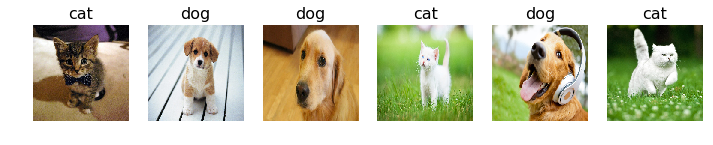

In [55]:
imgs, labels = next(imagesGen)
classes=['cat','dog']
predictions = vgg16.predict_generator(
    imagesGen
)
plots(imgs, titles=[classes[int(p)] for p in np.around(predictions[:,1])])